Hi people, in this post I will discuss different methodologies to perform Value at Risk backtesting so I hope you like it :D.

For Python I recommend that you use winpython (windows only, but it is portable) or anaconda (it is cross-platform, but requires installation). When installing any of these distributions you will find the executables Jupyter Notebook (the format of the post, the files have a .ipynb extension) and Spyder (IDE that I recommend to work with because it allows you to view the variables and their type, the files have a .py extension)

On the blog page I will leave the notebooks (they open with Jupyter notebook), the python scripts (I recommend using Spyder to work with these files) and the Excel files with the data used in the examples.
The topics that we will discuss in this post are:

Backtesting Normal VaR, CVaR and EVaR
Backtesting Historical VaR, CVaR and EVaR
Backtesting EWMA and GARCH(1,1) VaR
Conclusions

# 1 Backtesting Normal VaR, CVaR and EVaR

## 1.1 Downloading Data

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import yfinance as yf
#import riskfolio as rp
import warnings

warnings.filterwarnings("ignore")

# Date range
start = '2010-01-01'
end = '2022-12-30'

# List of assets
assets = ['^GSPC', 'JPM', 'MSFT', 'GOLD']

# Downloading the data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets
ret = data.pct_change().dropna()

display(ret.head())

[*********************100%%**********************]  4 of 4 completed


,^GSPC,JPM,MSFT,GOLD
Date,,,,
2010-01-05,0.012379,0.019369,0.000323,0.003116
2010-01-06,0.021277,0.005495,-0.006137,0.000546
2010-01-07,-0.014129,0.019809,-0.010400,0.004001
2010-01-08,0.006316,-0.002456,0.006897,0.002882
2010-01-11,0.005069,-0.003357,-0.012720,0.001747


## 1.2 Calculating Normal VaR, CVaR and EVaR.

Value at Risk (VaR) is the -quantile of the distribution of returns, it represents the largest possible loss given a level of significance.

Conditional Value at Risk (CVaR) is the average loss below VaR.

Entropic Value at Risk (EVaR) is the upper limit of VaR and CVaR based on the Chernoff inequality. If you want to know more about this risk measure, you can review this link.

Now we are going to calculate the three risk measures for all the assets we have downloaded:

In [3]:
n = ret.shape[0]

Risk_norm = {}
for i in assets:
    Risk_norm[i] = {'VaR':[], 'CVaR': [], 'EVaR': []}

window = 250 * 1
alpha = 0.05

for j in assets:
    for i in range(window, n):
        X = ret[j].iloc[i-window:i]
        z = st.norm.ppf(1 - alpha)
        mu, sigma = st.norm.fit(X)
        Risk_norm[j]['VaR'].append(mu - z * sigma)
        Risk_norm[j]['CVaR'].append(mu - sigma * st.norm.pdf(z) / alpha)
        Risk_norm[j]['EVaR'].append(mu - sigma * np.sqrt(-2 * np.log(alpha)))

for i in assets:
    Risk_norm[i] = pd.DataFrame(Risk_norm[i], index=ret.index[window:])

## 1.3 Plotting Normal VaR, CVaR and EVaR.

[]

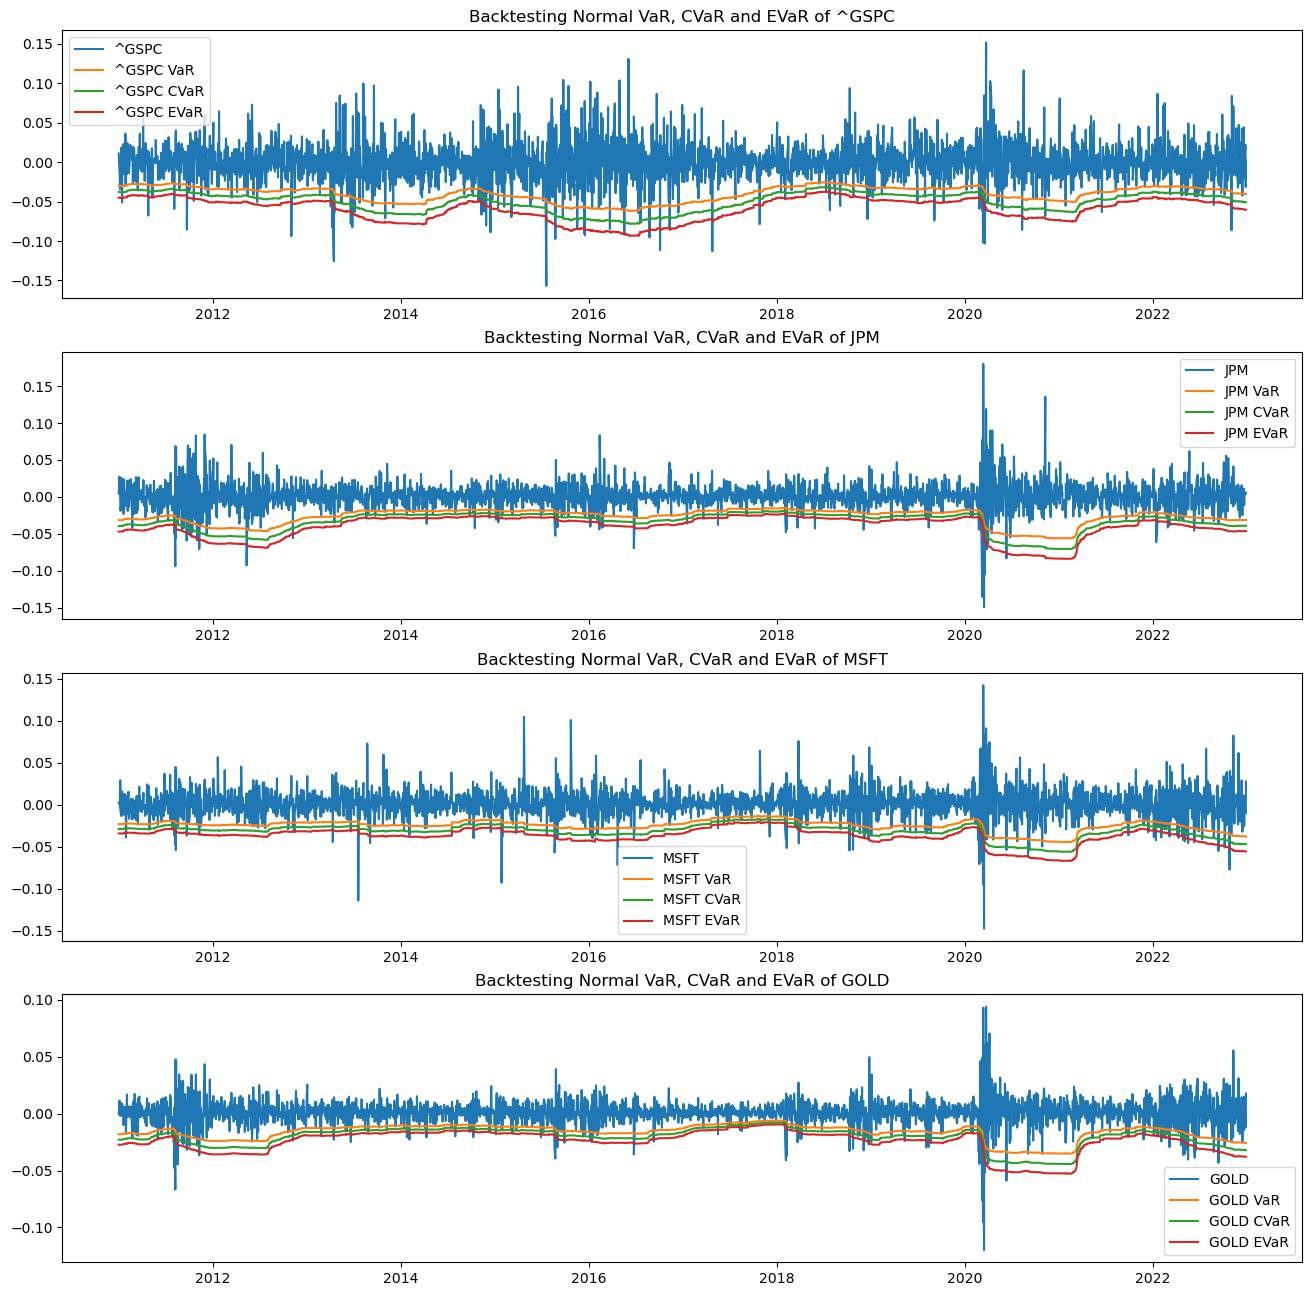

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(assets),1,figsize=(16, 16))

for i in range(len(assets)):
    ax[i].plot(ret[assets[i]].iloc[window:], label=assets[i])
    ax[i].plot(Risk_norm[assets[i]]['VaR'], label=assets[i] + ' VaR')
    ax[i].plot(Risk_norm[assets[i]]['CVaR'], label=assets[i] + ' CVaR')
    ax[i].plot(Risk_norm[assets[i]]['EVaR'], label=assets[i] + ' EVaR')
    ax[i].legend()
    ax[i].set_title('Backtesting Normal VaR, CVaR and EVaR of ' + assets[i])

plt.plot()

## 1.4 Making Formal Tests to Evaluate VaR Models:

We are going to use two tests to evaluate the quality of the VaR models:

The Kupiec test (1995) or coverage test or Bernoulli test. You can find the theory in this link

The Christofferson test (1998) or independente test. You can find the theory in this link

You can find the test code in this link.

In [7]:
def bern_test(p,v):
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    return (-2*(al-bl))

def ind_test(V):
    T = len(V)
    J = np.full([T,4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    return (-2*(al-bl))

In [8]:
keys = ['Failure Ratio VaR', 
        'Failure Ratio CVaR',
        'Failure Ratio EVaR',
        'Bernoulli Test VaR stat',
        'Bernoulli Test VaR p-value',
        'Bernoulli Test CVaR stat',
        'Bernoulli Test CVaR p-value',
        'Bernoulli Test EVaR stat',
        'Bernoulli Test EVaR p-value',
        'Independent Test VaR stat',
        'Independent Test VaR p-value',
        'Independent Test CVaR stat',
        'Independent Test CVaR p-value',
        'Independent Test EVaR stat',
        'Independent Test EVaR p-value']

Stats_norm = {}
    
for i in assets:
    Stats_norm[i] = {}
    for j in keys:
        Stats_norm[i][j] = []

for i in Stats_norm.keys():
    for j in Risk_norm[i].keys():
        a = np.minimum(ret[i].iloc[window:] - Risk_norm[i][j],0)
        H = np.count_nonzero(a)
        T = Risk_norm[i].shape[0]
        q = a < 0
        v = a * 0
        v[q] = 1
        ber = bern_test(alpha, v)
        ind = ind_test(v)
        Stats_norm[i]['Failure Ratio ' + j].append(H/T)
        Stats_norm[i]['Bernoulli Test ' + j + ' stat'].append(round(ber, 5))
        Stats_norm[i]['Bernoulli Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ber, 1),5))
        Stats_norm[i]['Independent Test ' + j + ' stat'].append(round(ind, 5))
        Stats_norm[i]['Independent Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ind, 1),5))
        
a = pd.DataFrame([])        
for i in assets:
    Stats_norm[i] = pd.DataFrame(Stats_norm[i]).T
    Stats_norm[i].columns = [i]
    a = pd.concat([a, Stats_norm[i]], axis=1)

Stats_norm = a
display(Stats_norm)

,^GSPC,JPM,MSFT,GOLD
Failure Ratio VaR,0.050993,0.049669,0.052318,0.059603
Failure Ratio CVaR,0.027815,0.031457,0.028477,0.037748
Failure Ratio EVaR,0.015894,0.017219,0.019536,0.028146
Bernoulli Test VaR stat,0.062350,0.006990,0.336700,5.537850
Bernoulli Test VaR p-value,0.802820,0.933390,0.561740,0.018610
Bernoulli Test CVaR stat,37.026830,25.039460,34.637240,10.388580
Bernoulli Test CVaR p-value,0.000000,0.000000,0.000000,0.001270
Bernoulli Test EVaR stat,99.630760,90.509790,76.029520,35.819930
Bernoulli Test EVaR p-value,0.000000,0.000000,0.000000,0.000000
Independent Test VaR stat,13.055350,39.398030,15.961850,20.603700


# 2 Backtesting Historical VaR, CVaR and EVaR

this section uses #import riskfolio as rp that has some https://snyk.io/advisor/python/riskfolio-lib volnerabilities

# 3 Backtesting EWMA and GARCH(1,1) VaR

## 3.1 Calculating Historical EWMA and GARCH(1,1) VaR .

In [ ]:
from arch import arch_model

n = ret.shape[0]

Risk_EG = {}
for i in assets:
    Risk_EG[i] = {'EWMA':[], 'GARCH': []}

window = 250 * 1
alpha = 0.05
l = 0.94
s = 0

for j in assets:
    for i in range(window, n):
        X = ret[j].iloc[i-window:i]
        z = st.norm.ppf(1 - alpha)
        mu, sigma = st.norm.fit(X)
        if i == window:
            s1 = sigma**2
        else:
            s1 = l * s1 + (1-l) * X[-2]**2
        
        VaR_ewma = -st.norm.ppf(1-alpha) * np.sqrt(s1)

        am = arch_model(X, mean='Zero',vol='Garch',
                        p=1, o=0, q=1, dist='Normal',
                        rescale=False)
        res = am.fit(update_freq=0, disp='off', show_warning=False)
        par = [res.params[0], res.params[1], res.params[2]]
        s2 = par[0] + par[1] * X[-2]**2 + par[2] * res.conditional_volatility[-1]**2
        VaR_garch = -np.sqrt(s2) * st.norm.ppf(1-alpha)
        
        Risk_EG[j]['EWMA'].append(VaR_ewma)
        Risk_EG[j]['GARCH'].append(VaR_garch)

for i in assets:
    Risk_EG[i] = pd.DataFrame(Risk_EG[i], index=ret.index[window:])

## 3.2 Plotting Historical EWMA and GARCH(1,1) VaR.

NameError: name 'Risk_EG' is not defined

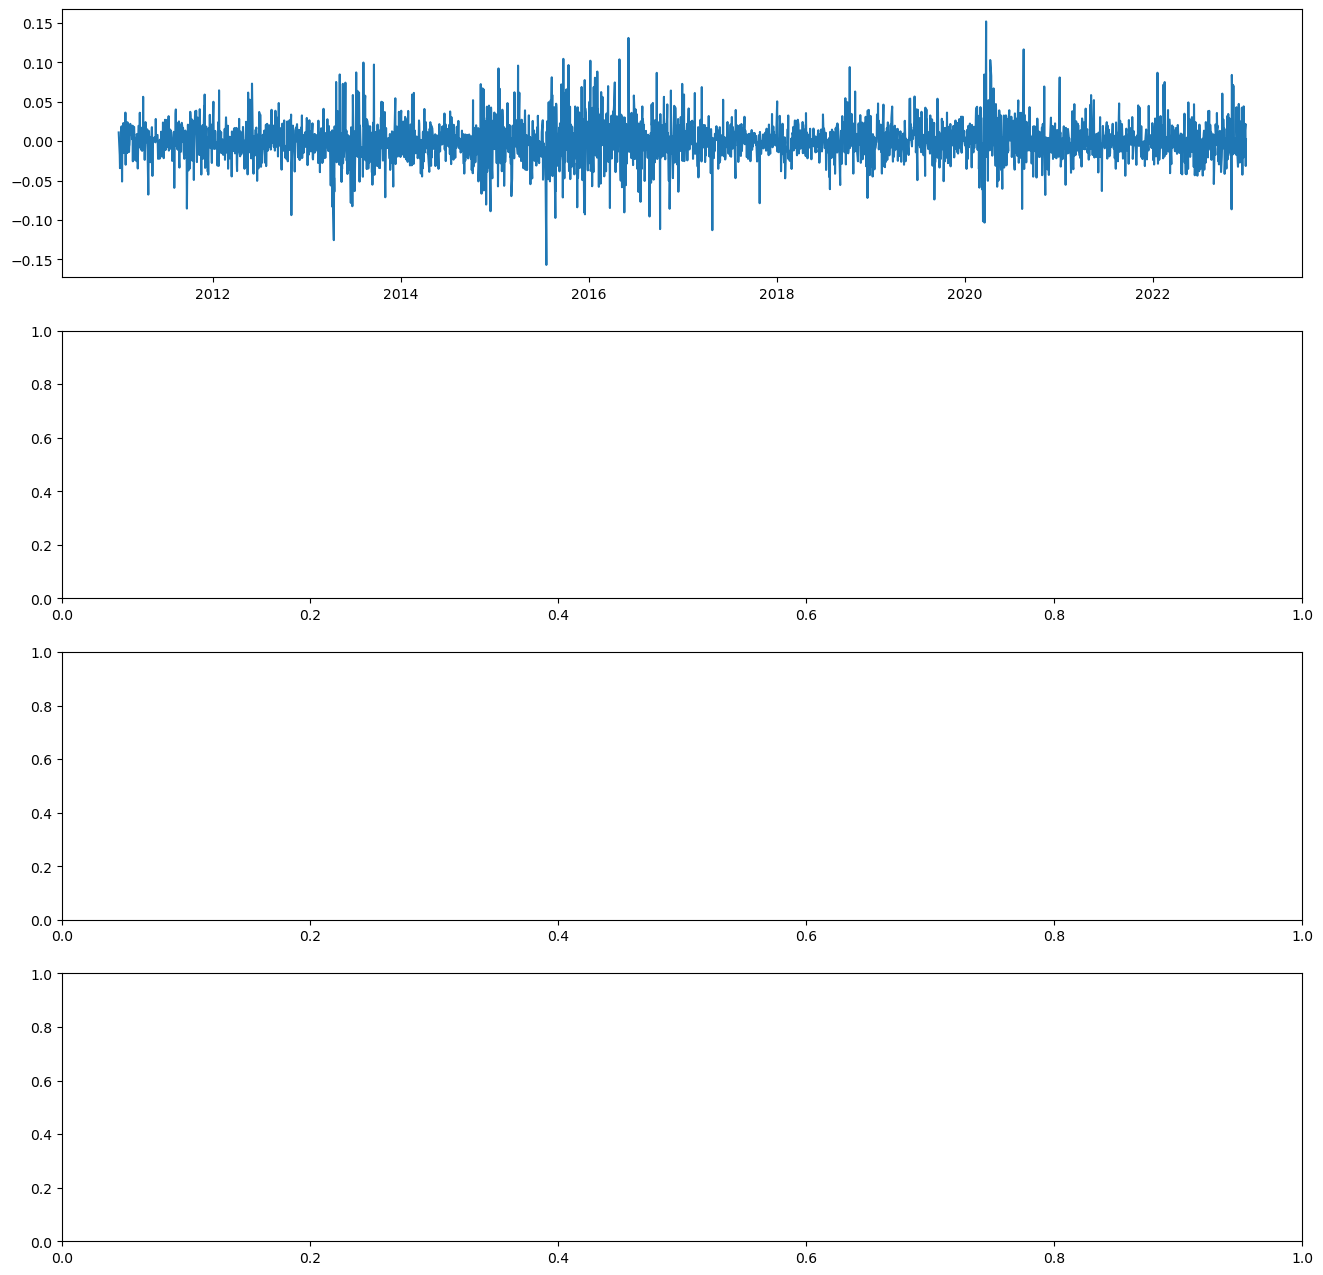

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(assets),1,figsize=(16, 16))

for i in range(len(assets)):
    ax[i].plot(ret[assets[i]].iloc[window:], label=assets[i])
    ax[i].plot(Risk_EG[assets[i]]['EWMA'], label=assets[i] + ' EWMA VaR')
    ax[i].plot(Risk_EG[assets[i]]['GARCH'], label=assets[i] + ' GARCH(1,1) VaR')
    ax[i].legend()
    ax[i].set_title('Backtesting EWMA and GARCH(1,1) VaR of ' + assets[i])

plt.plot()

## 3.3 Making Formal Tests to Evaluate VaR Models

In [10]:
keys = ['Failure Ratio EWMA', 
        'Failure Ratio GARCH',
        'Bernoulli Test EWMA stat',
        'Bernoulli Test EWMA p-value',
        'Bernoulli Test GARCH stat',
        'Bernoulli Test GARCH p-value',
        'Independent Test EWMA stat',
        'Independent Test EWMA p-value',
        'Independent Test GARCH stat',
        'Independent Test GARCH p-value']

Stats_EG = {}
    
for i in assets:
    Stats_EG[i] = {}
    for j in keys:
        Stats_EG[i][j] = []

for i in Stats_EG.keys():
    for j in Risk_EG[i].keys():
        a = np.minimum(ret[i].iloc[window:] - Risk_EG[i][j],0)
        H = np.count_nonzero(a)
        T = Risk_EG[i].shape[0]
        q = a < 0
        v = a * 0
        v[q] = 1
        ber = bern_test(alpha, v)
        ind = ind_test(v)
        Stats_EG[i]['Failure Ratio ' + j].append(H/T)
        Stats_EG[i]['Bernoulli Test ' + j + ' stat'].append(round(ber, 5))
        Stats_EG[i]['Bernoulli Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ber, 1),5))
        Stats_EG[i]['Independent Test ' + j + ' stat'].append(round(ind, 5))
        Stats_EG[i]['Independent Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ind, 1),5))
        
a = pd.DataFrame([])        
for i in assets:
    Stats_EG[i] = pd.DataFrame(Stats_EG[i]).T
    Stats_EG[i].columns = [i]
    a = pd.concat([a, Stats_EG[i]], axis=1)

Stats_EG = a
display(Stats_EG)

NameError: name 'Risk_EG' is not defined

Translation result
It can be seen that the EWMA and GARCH models do not offer substantial improvements with respect to the normal and historical VaR.